In [28]:
from marvin.tools.maps import Maps

import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

In [29]:
import sys
sys.path.insert(0, '/home/sshamsi/spirals/GZ3D_production')

import gz3d_fits

In [30]:
class SpiralGalaxy(object):
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = gz3d_fits.gz3d_fits(file_path)
        self.mangaid = self.data.metadata['MANGAID'][0]
        
        self.maps = Maps(self.mangaid)
        self.hamap = self.maps.emline_gflux_ha_6564
        self.hbmap = self.maps.emline_gflux_hb_4862
        self.eff_rad = self.maps.nsa['elpetro_th50_r'] * 2
        self.redshift = self.maps.nsa['z']
        self.mass = self.maps.nsa['sersic_mass']
        self.lgmass = np.log10(self.mass)
        self.elpetro_ba = self.maps.nsa['elpetro_ba']
        self.theta = np.radians(self.maps.nsa['elpetro_phi'] - 90.0)
        self.map_shape = self.hamap.shape
        
        self.d_mpc = ((299792.458 * self.redshift) / 70) #Mpc
        self.d_kpc = self.d_mpc * 1E3
        self.d_m = self.d_mpc * 3.085677581E+22 # m
        self.delta = (4 * np.pi * (self.d_m**2)) / ((2.8**2.36) * (10**41.1))
        self.spax_area = (0.0000024240684055477 * self.d_kpc)**2
        
        self.global_df_loaded = False
        self.bpt_masks_loaded = False
        self.r_array_loaded = False
        self.corr_matrix_loaded = False
        self.ha_cov_loaded = False
        self.hb_cov_loaded = False
        
        
    def __repr__(self):
        return 'MaNGA ID {}'.format(self.mangaid)
    
    
    def form_correllation_matrix(self):
        if not self.corr_matrix_loaded:
            self.corr_matrix = np.load('corr_matrices/corr_matrix' + str(self.map_shape[0]) + '.npy')
            self.corr_matrix_loaded = True
            
    
    def check_usability(self, threshold = 5, pix_percentage = 1.5):
        image_spiral_mask = self.data.spiral_mask
        pixels_above_threshold = (image_spiral_mask >= threshold).sum()
                
        if (pixels_above_threshold * 100 / image_spiral_mask.size < pix_percentage):
            return False
        
        return True
    
    
    def make_emmasks(self):
        self.ha_mask_array = self.hamap.mask.flatten()
        self.hb_mask_array = self.hbmap.mask.flatten()
        
        for i in range(len(self.ha_mask_array)):
            if self.ha_mask_array[i] & 1073741824 == 0:
                self.ha_mask_array[i] = 0
                self.hb_mask_array[i] = 0
            else:
                self.ha_mask_array[i] = 1
                if self.hb_mask_array[i] & 1073741824 == 0:
                    self.hb_mask_array[i] = 0
                else:
                    self.hb_mask_array[i] = 1
                    
        self.ha_mask_array = np.array(self.ha_mask_array, dtype=bool)
        self.hb_mask_array = np.array(self.hb_mask_array, dtype=bool)
        
        
    def make_r_array(self):
        if not self.r_array_loaded:
            r_array = np.array([])

            a, b = self.map_shape
            k, h = (a - 1) / 2.0, (b - 1) / 2.0 #map centre
            
            for y, x in [(y, x) for y in range(a) for x in range(b)]:
                j, i = (-1 * (y - k), x - h) #vector from centre
                
                spax_angle = (np.arctan(j / i)) - self.theta
                vec_len = (j**2.0 + i**2.0)**0.5
                r = vec_len * ((np.cos(spax_angle))**2.0 + ((np.sin(spax_angle))/self.elpetro_ba)**2.0)**0.5
                
                r_array = np.append(r_array, r)
                
            self.r_array = r_array
            
            self.r_array_loaded = True
    
        
    def update_spirals(self, spiral_threshold=3, other_threshold=3, ret_spiral_bool=False):
        self.data.make_all_spaxel_masks(grid_size = self.map_shape)
        
        center_mask_spaxel_bool = self.data.center_mask_spaxel > other_threshold
        star_mask_spaxel_bool = self.data.star_mask_spaxel > other_threshold
        bar_mask_spaxel_bool = self.data.bar_mask_spaxel > other_threshold
        spiral_mask_spaxel_bool = self.data.spiral_mask_spaxel > spiral_threshold
        
        combined_mask = center_mask_spaxel_bool | star_mask_spaxel_bool | bar_mask_spaxel_bool
        
        spiral_spaxel_bool = spiral_mask_spaxel_bool & (~combined_mask)
        
        if ret_spiral_bool:
            return spiral_spaxel_bool
        
        self.spiral_spaxel_bool = spiral_spaxel_bool
        self.df['Spiral Arm'] = spiral_spaxel_bool.flatten()
        
    
    def load_btp_masks(self):
        if not self.bpt_masks_loaded:
            bpt_masks = self.maps.get_bpt(return_figure=False, show_plot=False)

            self.comp = bpt_masks['comp']['global']
            self.agn = bpt_masks['agn']['global']
            self.seyfert = bpt_masks['seyfert']['global']
            self.liner = bpt_masks['liner']['global']
            
            self.bpt_masks_loaded = True
    
    
    def flux2sfr(self, ha_flux, ha_stdv, hb_flux, hb_stdv):
        ha_flux = ha_flux * 1E-13
        hb_flux = hb_flux * 1E-13
        
        ha_stdv = ha_stdv * 1E-13
        hb_stdv = hb_stdv * 1E-13
        
        sfr = (self.delta * (ha_flux**3.36) * (hb_flux**-2.36)) / self.spax_area
        sfr_stdv = np.sqrt((3.36 * self.delta * (ha_flux**2.36) * (hb_flux**-2.36) * ha_stdv)**2 +
                           (-2.36 * self.delta * (ha_flux**3.36) * (hb_flux**-3.36) * hb_stdv)**2) / self.spax_area
        
        return sfr, sfr_stdv
    
    
    def form_global_df(self, spiral_threshold=3, other_threshold=3):
        if not self.global_df_loaded:
            self.load_btp_masks()
            self.make_r_array()
            self.make_emmasks()
            
            ha_array = self.hamap.value.flatten()
            sig_ha_array = self.hamap.error.value.flatten()
            ha_snr = self.hamap.snr.flatten()
            
            hb_array = self.hbmap.value.flatten()
            sig_hb_array = self.hbmap.error.value.flatten()
            hb_snr = self.hbmap.snr.flatten()
            
            comp_array = self.comp.flatten()
            agn_array = self.agn.flatten()
            seyfert_array = self.seyfert.flatten()
            liner_array = self.liner.flatten()
            
            data_array = np.array([self.r_array, ha_array, sig_ha_array, ha_snr, hb_array, sig_hb_array, hb_snr,
                                   comp_array, agn_array, seyfert_array, liner_array]).transpose()
            
            df = pd.DataFrame(data=data_array, columns=['Radius', '$H_{\\alpha}$', '$\sigma H_{\\alpha}$',
                                                        'S/N $H_{\\alpha}$', '$H_{\\beta}$', '$\sigma H_{\\beta}$',
                                                        'S/N $H_{\\beta}$', 'Comp', 'AGN', 'Seyfert', 'Liner'])
            
            df['$r/r_e$'] = df['Radius'] / self.eff_rad
            
            df.iloc[self.ha_mask_array, df.columns.get_loc('$H_{\\alpha}$')] = np.nan
            df.iloc[self.ha_mask_array, df.columns.get_loc('$\sigma H_{\\alpha}$')] = np.nan
            df.iloc[self.ha_mask_array, df.columns.get_loc('$H_{\\beta}$')] = np.nan
            df.iloc[self.ha_mask_array, df.columns.get_loc('$\sigma H_{\\beta}$')] = np.nan
            
            df.iloc[self.hb_mask_array, df.columns.get_loc('$H_{\\beta}$')] = np.nan
            df.iloc[self.hb_mask_array, df.columns.get_loc('$\sigma H_{\\beta}$')] = np.nan
            
            df = df.replace([np.inf, -np.inf], np.nan)
            
            self.df = df
            self.update_spirals(spiral_threshold=spiral_threshold, other_threshold=other_threshold)
            
            self.global_df_loaded = True
            
            
    def cov_matrix_maker(self, err_series):
        r = self.hamap.size
        cov_mat = np.zeros((r, r))
        
        for item, frame in err_series.iteritems():
            if pd.isnull(frame):
                k = 0
            else:
                k = frame
                
            cov_mat[item] = self.corr_matrix[item] * k
            cov_mat[:, item] = self.corr_matrix[:, item] * k
        
        return cov_mat
    
    
    def make_cov_matrices(self, mode=None):
        self.form_correllation_matrix()
        
        if mode == None:
            raise ValueError('Argument "mode" must be set to "ha" or "hb".')
            
        elif mode == 'ha':
            if not self.ha_cov_loaded:
                self.ha_cov = self.cov_matrix_maker(self.df['$\sigma H_{\\alpha}$'])
                self.ha_cov_loaded = True
        
        elif mode == 'hb':
            if not self.hb_cov_loaded:
                self.hb_cov = self.cov_matrix_maker(self.df['$\sigma H_{\\beta}$'])
                self.hb_cov_loaded = True
                
                
    def get_sfr(self, index, avg=False):
        ha_flux, ha_stdv = self.get_emission(index, mode='ha', avg=avg)
        hb_flux, hb_stdv = self.get_emission(index, mode='hb', avg=avg)
        
        return self.flux2sfr(ha_flux, ha_stdv, hb_flux, hb_stdv)
    
    
    def get_emission(self, index, mode=None, avg=False):
        set_index = set(index)
        tot_index = list(self.df.index)
        
        w_vec = np.array([[x in set_index for x in tot_index]]) * 1
        
        if mode == None:
            raise ValueError('Argument "mode" must be "ha", or "hb".')
        elif mode == 'ha':
            summ = self.df.loc[index.tolist(), '$H_{\\alpha}$'].sum()
            
            self.make_cov_matrices(mode=mode)
            cov_mat = self.ha_cov
        elif mode == 'hb':
            summ = self.df.loc[index.tolist(), '$H_{\\beta}$'].sum()
            
            self.make_cov_matrices(mode=mode)
            cov_mat = self.hb_cov
            
        var = np.linalg.multi_dot([w_vec, cov_mat, w_vec.T])[0][0]
        
        if avg:
            n = len(index)
            return summ / n, np.sqrt(var / (n**2))
        
        return summ, np.sqrt(var)

In [31]:
gal = SpiralGalaxy('/home/sshamsi/sas/mangawork/manga/sandbox/galaxyzoo3d/v1_0_0/1-147485_127_5679396.fits.gz')

/home/sshamsi/miniconda3/envs/marvin/lib/python3.7/site-packages/marvin/utils/general/general.py:1086: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  value = np.asscalar(value)


In [32]:
gal.form_global_df()

In [33]:
gal.df[gal.df['Spiral Arm'] == 1]

,Radius,$H_{\alpha}$,$\sigma H_{\alpha}$,S/N $H_{\alpha}$,$H_{\beta}$,$\sigma H_{\beta}$,S/N $H_{\beta}$,Comp,AGN,Seyfert,Liner,$r/r_e$,Spiral Arm
1824,28.872250,3.917789,0.052844,74.138374,0.873440,0.040688,21.466625,0.0,0.0,0.0,0.0,1.584011,True
1825,29.638063,3.418037,0.052556,65.036087,0.793273,0.040374,19.648214,0.0,0.0,0.0,0.0,1.626026,True
1826,30.423879,3.207788,0.043525,73.699478,0.737097,0.037025,19.907902,0.0,0.0,0.0,0.0,1.669138,True
1827,31.228190,3.086082,0.041484,74.391579,0.701689,0.035954,19.516407,0.0,0.0,0.0,0.0,1.713265,True
1831,34.604145,2.931139,0.041420,70.765892,0.740916,0.035976,20.594666,0.0,0.0,0.0,0.0,1.898479,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3736,24.096402,1.678588,0.037468,44.800262,0.527622,0.035799,14.738585,0.0,0.0,0.0,0.0,1.321995,True
3737,23.732152,1.697988,0.041593,40.824230,0.528608,0.040413,13.080182,0.0,0.0,0.0,0.0,1.302011,True
3803,29.444877,2.261810,0.041892,53.990974,0.625910,0.037017,16.908812,0.0,0.0,0.0,0.0,1.615427,True
3804,28.836792,1.873624,0.042296,44.297913,0.525877,0.035482,14.821133,0.0,0.0,0.0,0.0,1.582066,True


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f55fc1bee10>)

/home/sshamsi/miniconda3/envs/marvin/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/sshamsi/miniconda3/envs/marvin/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


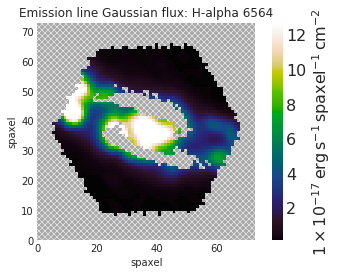

In [34]:
gal.hamap.plot(mask=gal.spiral_spaxel_bool)

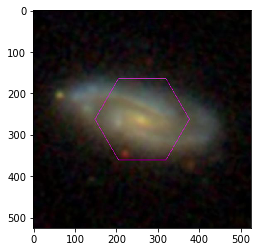

In [25]:
plt.imshow(gal.data.image)

In [24]:
import matplotlib.pyplot as plt

In [26]:
gal.update_spirals(spiral_threshold=2)